# Exercise 5
## 3 Constructing the Matrix X

In [470]:
#import libraries
import matplotlib.pyplot as plt
import numpy as np
from scipy import sparse

In [471]:
def get_coords(M, Np):
    '''
    A function that computes the coordinates for each pixel. The origin is in the center of the image.
    A pixel distance of 1 is assumed.
    
    input:   
        M         An integer, number of pixels in each dimension
        Np        An integer, number of sensor pixels
    output:
        A numpy array of shape (2, M*M), contains coordinates of each pixel
    '''
    y, x = np.mgrid[0:M,0:M]
    x = x.flatten() - (M-1)/2 
    y = -1*(y.flatten() - (M-1)/2)
    
    return np.array([x, y])

In [472]:
def get_ns(alphas):
    '''
    Creates an array of vectors that lies in the straight line defined by the detector.
    These are perpendicular to the corresponding normal vectors.
    
    input:
        alphas    An array containing the rotation angles of the detector
        
    output:
        A numpy array of shape (2, len(alphas)) containing vectors in the straight lines
        defined by the detector.
    '''
    
    return np.array([np.cos(alphas), np.sin(alphas)])    

In [473]:
def construct_X(M, alphas, Np=None):
    #create a value for Np if no value is given
    if (Np == None): Np = int(np.sqrt(2) * M) + 1
        
    alphas = np.pi/180 * np.array(alphas)
    N = Np * len(alphas)
    D = M*M
    
    #compute the pixel coordinates
    C = get_coords(M, Np)
    
    #compute the vectors to project on
    ns = get_ns(alphas)
    
    #do the projection
    p = np.dot(ns.transpose(), C) + (Np-1)/2
    
    #compute j indices
    j_indices1 = np.floor(p)
    j_indices2 = j_indices1+1
    j_indices = np.concatenate((j_indices1, j_indices2), axis=0)
    shift_mask = np.concatenate((np.arange(len(alphas)), (np.arange(len(alphas))))) * Np
    j_shift = np.ones(np.shape(j_indices))*np.array([shift_mask]).transpose() 
    
    #compute i indices
    i_indices = np.ones(np.shape(j_indices)) * np.arange(M*M)
    
    #compute weights
    weights1 = j_indices1 - p + 1
    weights2 = p - j_indices1
    weights = np.concatenate((weights1, weights2), axis=0)
    
    #filter entries with invalid indices
    filter_cond = np.logical_and(j_indices>-1,j_indices<Np)
    weights = weights[filter_cond]
    i_indices = np.array(i_indices[filter_cond], dtype=int)
    j_indices = np.array(j_indices[filter_cond] + j_shift[filter_cond], dtype=int)
    
    #filter entries where weights is zero
    filter_cond = (weights > 1e-14)
    i_indices = i_indices[filter_cond]
    j_indices = j_indices[filter_cond]
    weights = weights[filter_cond]
    
    
    X = sparse.coo_matrix((weights, (j_indices, i_indices)), shape=(N,D), dtype=np.float32)
    
    return X

Now we check if our code is correct by comparing it to the example from the provided data. Indeed both images look very similar. The image of the difference of both matrices shows that both matrices are equal to each other.

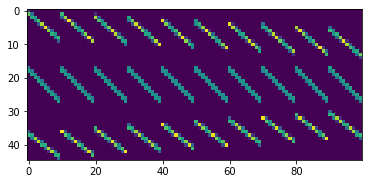

In [474]:
X = construct_X(10, [-33, 1, 42])
X = X.todense()
plt.imshow(X)


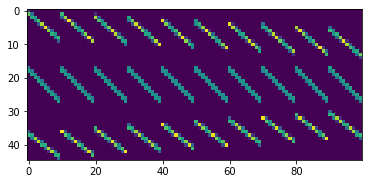

In [475]:
X_sol = np.load("hs_tomography/X_example.npy")
plt.imshow(X_sol)

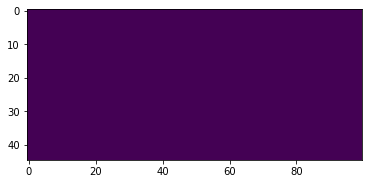

In [476]:
plt.imshow(X-X_sol)

## 4 Recovering the image

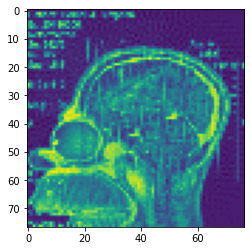

In [491]:
#constructing the low resolution image
alphas = np.load("hs_tomography/alphas_77.npy")
y = np.load("hs_tomography/y_77.npy")
M=77
Np=109

X = construct_X(M, alphas, Np)
beta = sparse.linalg.lsqr(X, y, atol=1e-5, btol=1e-5)[0]
beta = np.reshape(beta, (M,M))
plt.imshow(beta)

In [493]:
print("The matrix X has ", X.count_nonzero(), " nonzero entries.")
n = M*M * Np*len(y)
print("This corresponds to ", np.round(X.count_nonzero()/n,5) ,"% of the entries.")

The matrix X has  1066978  nonzero entries.
This corresponds to  0.00017 % of the entries.


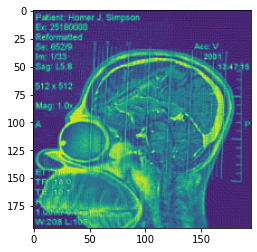

In [481]:
#constructing the high resolution image
alphas = np.load("hs_tomography/alphas_195.npy")
y = np.load("hs_tomography/y_195.npy")
M=195
Np=275

X = construct_X(M, alphas, Np)
beta = sparse.linalg.lsqr(X, y, atol=1e-5, btol=1e-5)[0]
beta = np.reshape(beta, (M,M))
plt.imshow(beta)

One can see that the patient has a pen inside his brain.

## 5 Minimizing the radiation dose

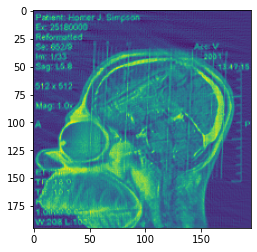

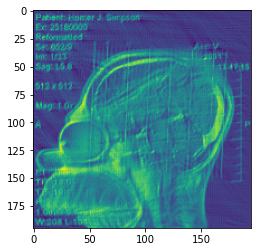

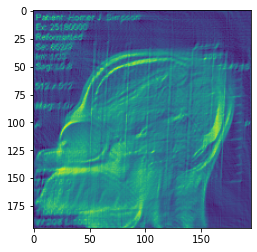

In [498]:
alphas = np.load("hs_tomography/alphas_195.npy")
y = np.load("hs_tomography/y_195.npy")
M=195
Np=275

n_scans = [149, 119, 89]
for n in n_scans:
    #reduce the number of angles
    n_alphas = alphas[:n]
    n_y = y[:n*Np]
    
    #compute and plot the image
    X = construct_X(M, n_alphas, Np)
    beta = sparse.linalg.lsqr(X, n_y, atol=1e-5, btol=1e-5)[0]
    beta = np.reshape(beta, (M,M))
    plt.figure(n)
    plt.imshow(beta)

We reduced the number of scans in steps of 30. We can see that the pen is still visible for 149 and 119 scans, while it is getting hard to recognize for 89 scans.